# Import library

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Setting parameter

In [82]:
# reference concentration and numbers, concentration in mM
r1_c1 = 5.45 /1000 #mM
n11 = 2
r1_c2 = 2.73 /1000
n12 = 2

r2_c1 = 22 /1000
n21 = 3
r2_c2 = 11 /1000
n22 = 3

r3_c1 = 3.1 /1000
n31 = 3
r3_c2 = 1.55 /1000
n32 = 2

# sample numbers and numbers of spectra for each sample
sample_num = 2
s_per_sam = [2, 3]

# spectrum fitting range
spectrum_low = 270
spectrum_high = 400

# Loading reference spectra

## Normlization

In [84]:
# read data
df_x_origin = pd.read_csv('data/2023-09-14_reference.csv')
df_x_origin = df_x_origin.set_index('Unnamed: 0')
df_x = df_x_origin.loc[str(spectrum_low):str(spectrum_high)]

# read reference of solvent
ref_solvent = np.load('bkg_spectrum.npy')
ref_solvent = pd.DataFrame(ref_solvent).set_index(0)
ref_solvent = ref_solvent.loc[str(spectrum_low):str(spectrum_high+1)]
df_x['bkg'] = ref_solvent

# get standard curve of reference1
pos = 0
df_x['r1_c1'] = df_x.iloc[:, pos:pos+n11].sum(axis=1)/n11 - ref_solvent[1]
pos += n11
df_x['r1_c2'] = df_x.iloc[:, pos:pos+n12].sum(axis=1)/n12 - ref_solvent[1]
pos += n12
X = pd.DataFrame(index=df_x.index)
X['r1'] = 0.5 * (df_x['r1_c1']/r1_c1 + df_x['r1_c2']/r1_c2)

# get standard curve of reference2
df_x['r2_c1'] = df_x.iloc[:, pos:pos+n21].sum(axis=1)/n21 - ref_solvent[1]
pos += n21
df_x['r2_c2'] = df_x.iloc[:, pos:pos+n22].sum(axis=1)/n22 - ref_solvent[1]
pos += n22
X['r2'] = 0.5 * (df_x['r2_c1']/r2_c1 + df_x['r2_c2']/r2_c2)

# get standard curve of reference3
df_x['r3_c1'] = df_x.iloc[:, pos:pos+n31].sum(axis=1)/n31 - ref_solvent[1]
pos += n31
df_x['r3_c2'] = df_x.iloc[:, pos:pos+n32].sum(axis=1)/n32 - ref_solvent[1]
pos += n32
X['r3'] = 0.5 * (df_x['r3_c1']/r3_c1 + df_x['r3_c2']/r3_c2)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20224\2199394294.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['bkg'] = ref_solvent
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20224\2199394294.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['r1_c1'] = df_x.iloc[:, pos:pos+n11].sum(axis=1)/n11 - ref_solvent[1]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20224\2199394294.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

## Interpolate

In [113]:
c1 = np.array([0, r1_c1, r1_c2])
f_r1 = interpolate.interp1d(c1, df_x[['bkg', 'r1_c1', 'r1_c2']], bounds_error=False, fill_value="extrapolate")
X1 = pd.DataFrame(index=df_x.index)
X1['r1'] = f_r1(1)

c1 = np.array([0, r2_c1, r2_c2])
f_r1 = interpolate.interp1d(c1, df_x[['bkg', 'r2_c1', 'r2_c2']], bounds_error=False, fill_value="extrapolate")
X1['r2'] = f_r1(1)

c1 = np.array([0, r3_c1, r3_c2])
f_r1 = interpolate.interp1d(c1, df_x[['bkg', 'r3_c1', 'r3_c2']], bounds_error=False, fill_value="extrapolate")
X1['r3'] = f_r1(1)

# Loading sample spectra

In [86]:
df_y_origin = pd.read_csv('data/2023-09-14_sample.csv')
df_y_origin = df_y_origin.set_index('Unnamed: 0')

# selecting spectrum range
df_y = df_y_origin.loc[str(spectrum_low):str(spectrum_high)]

#substrate solvent
df_y = df_y.subtract(ref_solvent[1], axis=0)

y_pred = pd.DataFrame(index=df_x.index, columns=df_y.columns)

# Fitting and plotting

## Linear regression

In [106]:
concentration = pd.DataFrame(columns=['ref1', 'ref2', 'ref3'])

# creating a regression model
model = LinearRegression(fit_intercept=False, positive=True)
for ind, col in df_y.iteritems():
    model.fit(X, col)
    concentration.loc[ind] = model.coef_
    y_pred[ind] = model.predict(X)
concentration

,ref1,ref2,ref3
0,0.001003,0.001157,0.002740
1,0.001088,0.000729,0.002418
2,0.001124,0.003581,0.000437
3,0.000852,0.005286,0.000714
4,0.001146,0.004177,0.000521


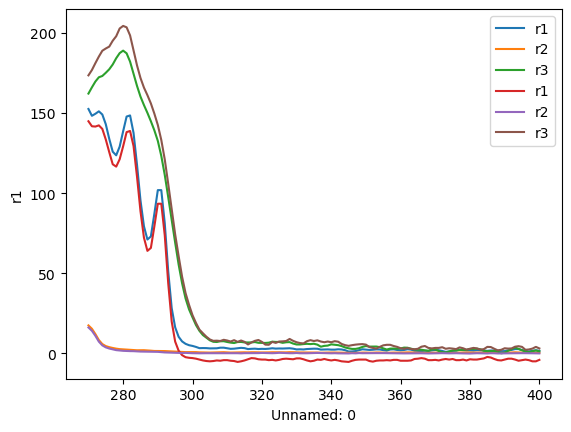

In [107]:
# plot reference
for ind, col in X.iteritems():
    sns.lineplot(x=X.index, y=col, label=ind)
#sns.lineplot(x=X.index, y=f_r1(1), label=ind)
for ind, col in X1.iteritems():
    sns.lineplot(x=X1.index, y=col, label=ind)

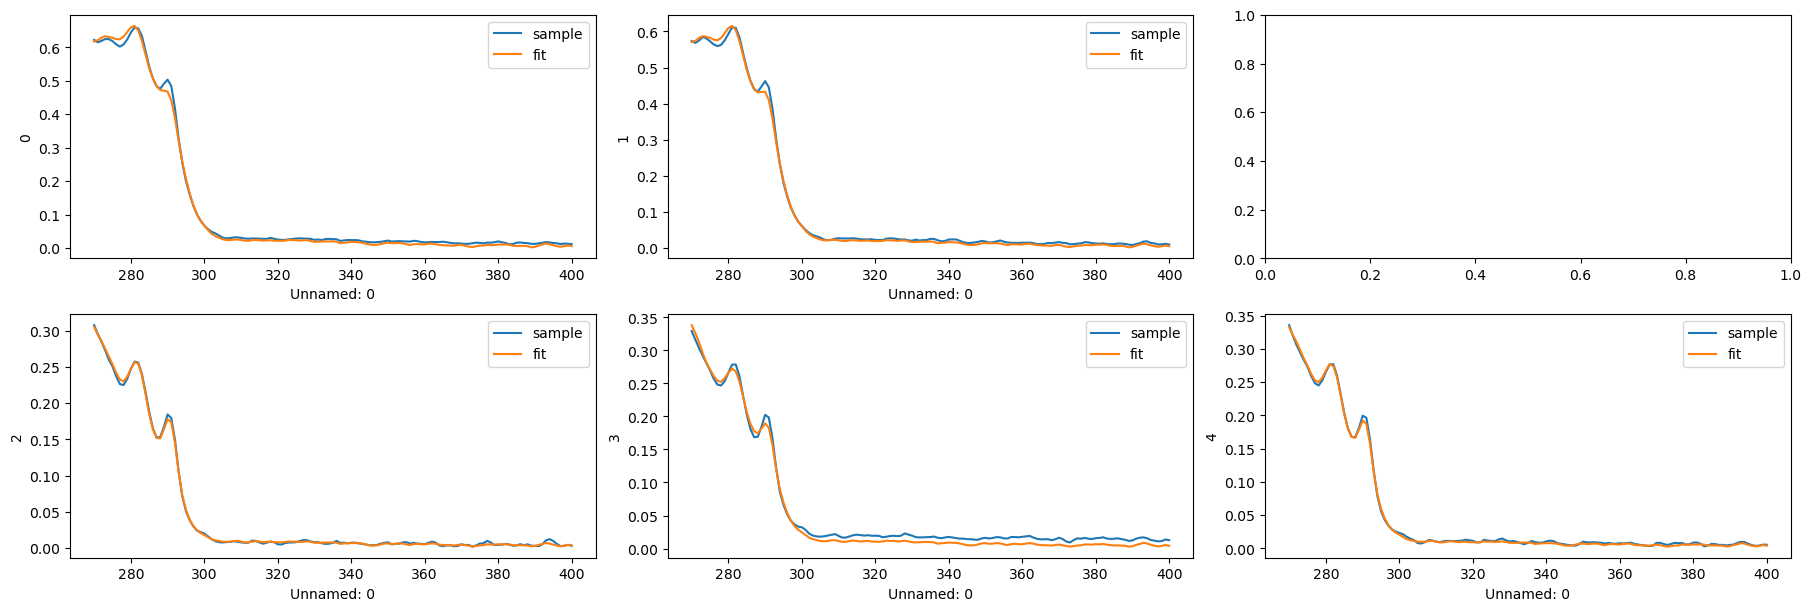

In [108]:
# plot figure
fig1, ax1 =plt.subplots(sample_num, max(s_per_sam), constrained_layout=True, figsize=(18, 6))
for i in range(len(df_y.columns)):
    if i < s_per_sam[0]:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]], label='sample', ax=ax1[0,i])
        axesSub = sns.lineplot(x=df_y.index, y=y_pred[y_pred.columns[i]], label='fit', ax=ax1[0,i])
    else:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]], label='sample', ax=ax1[1,i-s_per_sam[0]])
        axesSub = sns.lineplot(x=df_y.index, y=y_pred[y_pred.columns[i]], label='fit', ax=ax1[1,i-s_per_sam[0]])

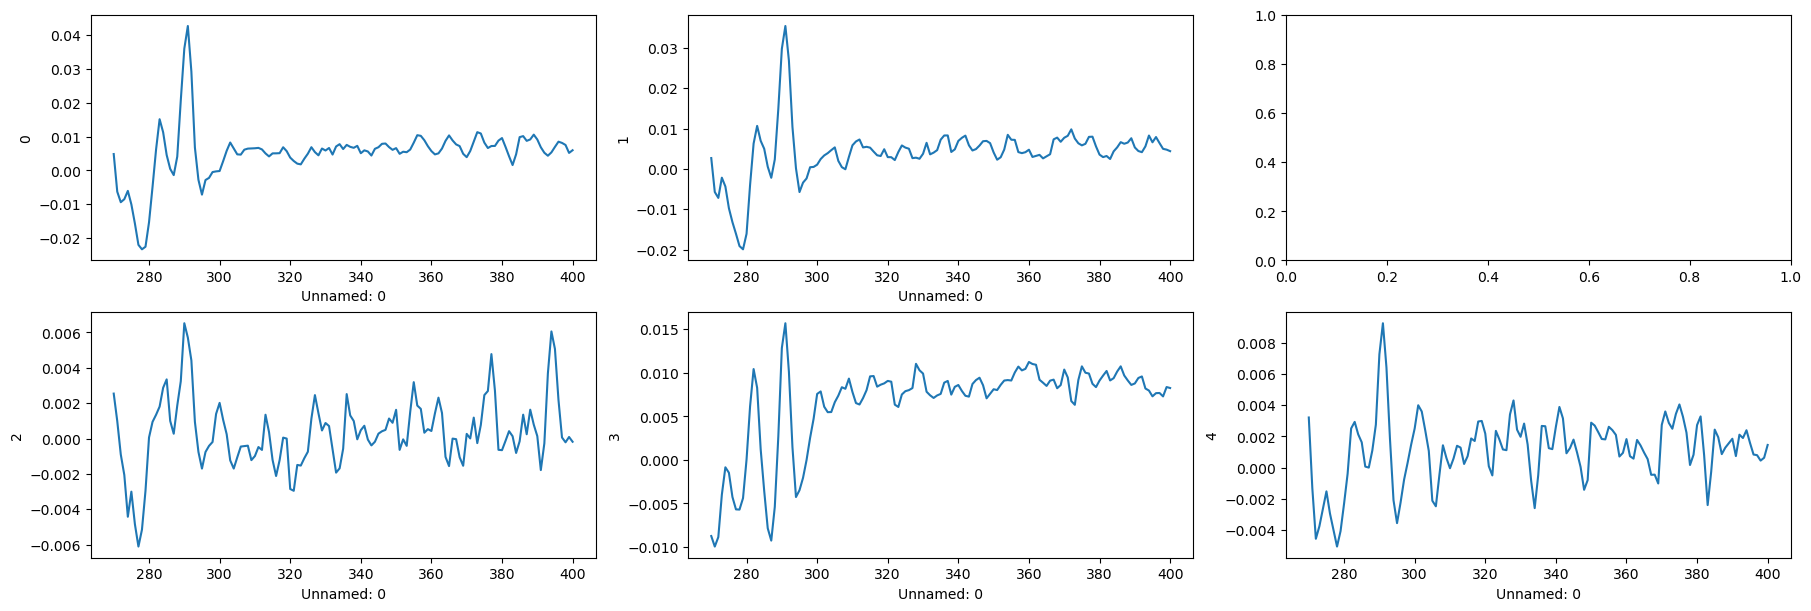

In [109]:
#plotting error
fig2, ax2 =plt.subplots(sample_num, max(s_per_sam), constrained_layout=True, figsize=(18, 6))
for i in range(len(df_y.columns)):
    if i < s_per_sam[0]:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]]-y_pred[y_pred.columns[i]], ax=ax2[0,i])
    else:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]]-y_pred[y_pred.columns[i]], ax=ax2[1,i-s_per_sam[0]])

## SVR

In [110]:
concentration2 = pd.DataFrame(columns=['ref1', 'ref2', 'ref3'])

# creating a regression model
model2 = SVR(epsilon=0.005, kernel='linear')
for ind, col in df_y.iteritems():
    model2.fit(X, col)
    concentration2.loc[ind] = model2.coef_[0]
    y_pred[ind] = model2.predict(X)
concentration2

,ref1,ref2,ref3
0,0.001051,0.000361,0.002665
1,0.001150,0.000297,0.002335
2,0.001234,0.003171,0.000347
3,0.001211,0.003379,0.000424
4,0.001241,0.003689,0.000444


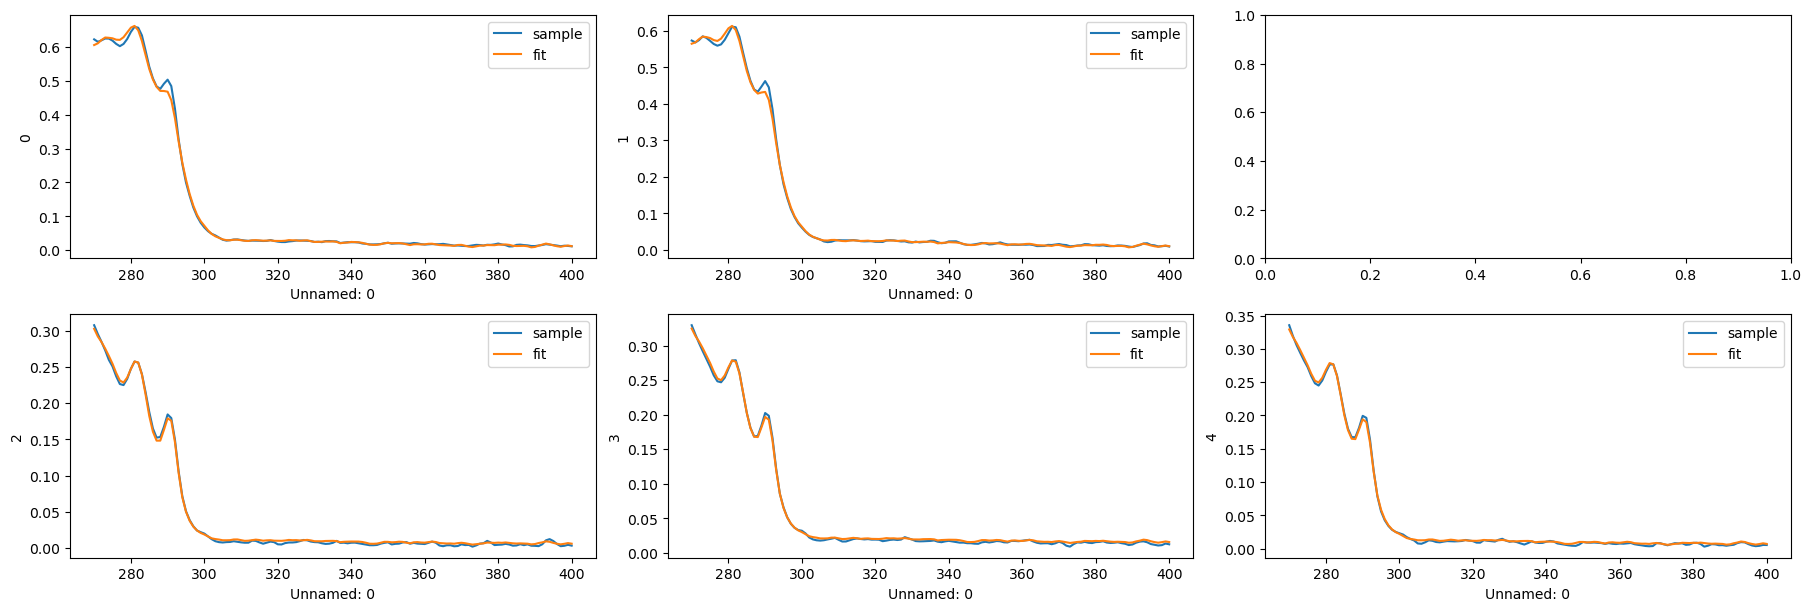

In [111]:
# plot figure
fig1, ax1 =plt.subplots(sample_num, max(s_per_sam), constrained_layout=True, figsize=(18, 6))
for i in range(len(df_y.columns)):
    if i < s_per_sam[0]:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]], label='sample', ax=ax1[0,i])
        axesSub = sns.lineplot(x=df_y.index, y=y_pred[y_pred.columns[i]], label='fit', ax=ax1[0,i])
    else:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]], label='sample', ax=ax1[1,i-s_per_sam[0]])
        axesSub = sns.lineplot(x=df_y.index, y=y_pred[y_pred.columns[i]], label='fit', ax=ax1[1,i-s_per_sam[0]])

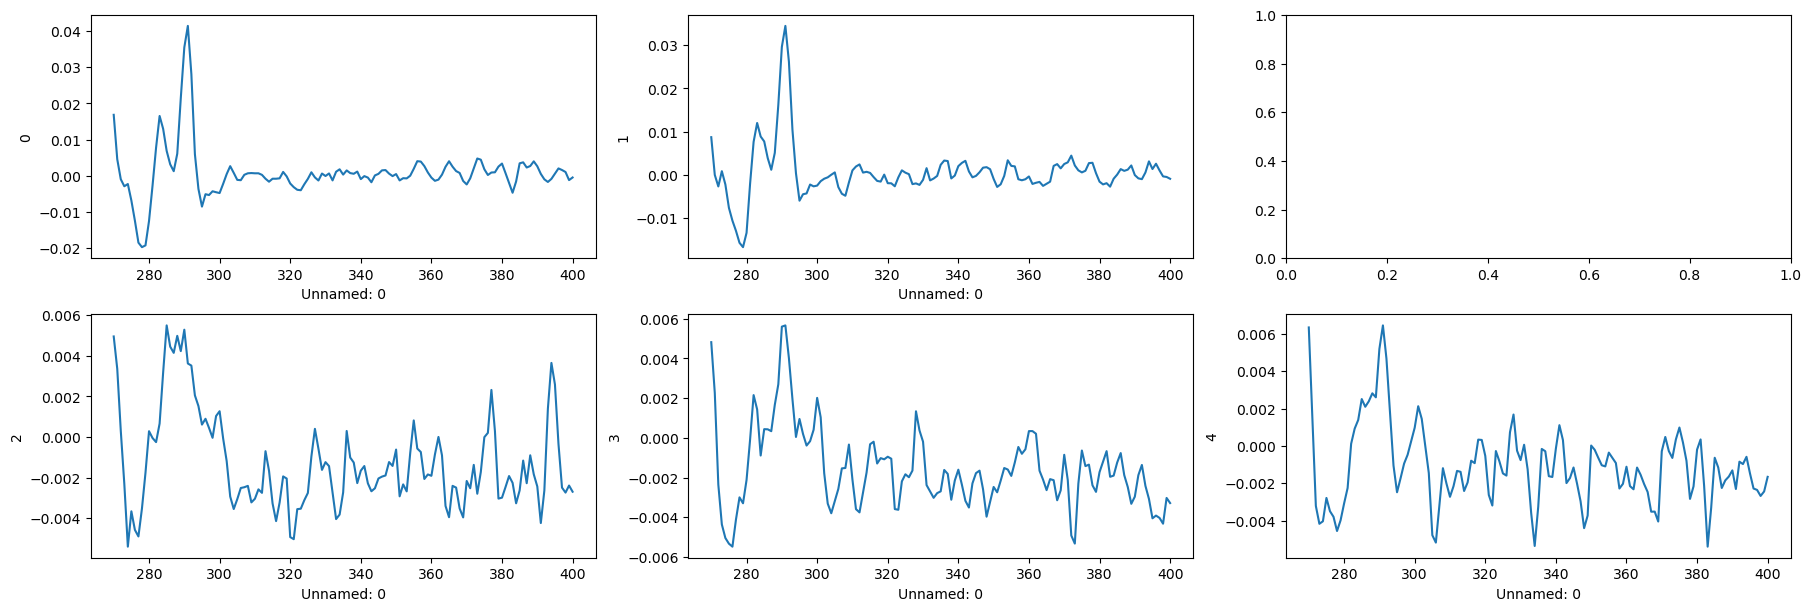

In [112]:
#plotting error
fig2, ax2 =plt.subplots(sample_num, max(s_per_sam), constrained_layout=True, figsize=(18, 6))
for i in range(len(df_y.columns)):
    if i < s_per_sam[0]:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]]-y_pred[y_pred.columns[i]], ax=ax2[0,i])
    else:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]]-y_pred[y_pred.columns[i]], ax=ax2[1,i-s_per_sam[0]])

# Export results